# Week 6 Homework

This notebook contains implementation on tree based models taught in week 6

In [1]:
import re
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from sklearn.feature_extraction import DictVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import export_text


%matplotlib inline

In [2]:
! wget https://raw.githubusercontent.com/alexeygrigorev/datasets/master/housing.csv

--2022-10-17 16:00:39--  https://raw.githubusercontent.com/alexeygrigorev/datasets/master/housing.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1423529 (1.4M) [text/plain]
Saving to: ‘housing.csv.1’

housing.csv.1       100%[===================>]   1.36M   299KB/s    in 5.1s    

2022-10-17 16:00:45 (272 KB/s) - ‘housing.csv.1’ saved [1423529/1423529]



In [3]:
FILE_PATH = "./housing.csv"
select_cols = ["longitude", "latitude", "housing_median_age", "total_rooms", "total_bedrooms", "population", "households", 
               "median_income", "median_house_value", "ocean_proximity"]

In [4]:
df = pd.read_csv(FILE_PATH, usecols=select_cols)

In [5]:
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [6]:
df.sample(8)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
5213,-118.28,33.93,52.0,117.0,33.0,74.0,45.0,0.4999,90600.0,<1H OCEAN
2778,-115.73,33.35,23.0,1586.0,448.0,338.0,182.0,1.2132,30000.0,INLAND
20353,-119.05,34.13,12.0,57.0,22.0,69.0,15.0,5.0066,275000.0,NEAR OCEAN
8386,-118.36,33.98,46.0,1425.0,283.0,782.0,273.0,5.0570,246300.0,<1H OCEAN
8198,-118.15,33.79,5.0,3700.0,993.0,1657.0,848.0,3.7826,196300.0,NEAR OCEAN
16386,-121.27,38.05,26.0,378.0,75.0,164.0,65.0,3.4107,82800.0,INLAND
8096,-118.21,33.81,45.0,1693.0,337.0,1255.0,333.0,3.6923,159700.0,NEAR OCEAN
16656,-120.66,35.27,33.0,1664.0,455.0,1077.0,461.0,1.6875,174200.0,NEAR OCEAN


In [7]:
df.isnull().sum()

longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        207
population              0
households              0
median_income           0
median_house_value      0
ocean_proximity         0
dtype: int64

In [8]:
df.total_bedrooms = df.total_bedrooms.fillna(0)

In [9]:
df.isnull().sum()

longitude             0
latitude              0
housing_median_age    0
total_rooms           0
total_bedrooms        0
population            0
households            0
median_income         0
median_house_value    0
ocean_proximity       0
dtype: int64

In [10]:
df.median_house_value = np.log1p(df.median_house_value)

In [11]:
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,13.022766,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,12.789687,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,12.771673,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,12.740520,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,12.743154,NEAR BAY


In [12]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

In [13]:
# sanity check
(len(df_train) / len(df)), (len(df_val) / len(df)), (len(df_val) / len(df))

(0.6, 0.2, 0.2)

In [14]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [15]:
y_train = df_train.median_house_value.values
y_val = df_val.median_house_value.values
y_test = df_test.median_house_value.values

In [16]:
# drop target column
df_train = df_train.drop('median_house_value', axis=1)
df_val = df_val.drop('median_house_value', axis=1)
df_test = df_test.drop('median_house_value', axis=1)

In [17]:
df_train.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
0,-118.18,34.63,19.0,3562.0,606.0,1677.0,578.0,4.1573,INLAND
1,-116.90,34.69,10.0,337.0,102.0,108.0,50.0,0.4999,INLAND
2,-118.26,33.78,27.0,1672.0,491.0,1723.0,462.0,2.0458,NEAR OCEAN
3,-117.33,34.17,5.0,4718.0,1140.0,2564.0,1056.0,2.9877,INLAND
4,-119.02,35.35,42.0,1239.0,251.0,776.0,272.0,1.9830,INLAND


### Question 1

In [18]:
train_dicts = df_train.to_dict(orient='records')
val_dicts = df_val.to_dict(orient='records')

In [19]:
dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(train_dicts)
X_val = dv.transform(val_dicts)

In [20]:
dt = DecisionTreeRegressor(max_depth=1)
dt.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=1)

In [21]:
print(export_text(dt, feature_names=dv.get_feature_names()))

|--- ocean_proximity=INLAND <= 0.50
|   |--- value: [12.31]
|--- ocean_proximity=INLAND >  0.50
|   |--- value: [11.61]



/home/princewillingoo/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


The answer is `ocean_proximity=INLAND <=0.50` 

### Question 2

In [22]:
rf = RandomForestRegressor(n_estimators=10, random_state=1, n_jobs=1)
rf.fit(X_train, y_train)

RandomForestRegressor(n_estimators=10, n_jobs=1, random_state=1)

In [23]:
y_pred = rf.predict(X_val)

In [24]:
y_pred

array([12.70112608, 13.10869355, 11.20721472, ..., 12.74865454,
       12.3279425 , 12.29711708])

In [25]:
np.sqrt(mean_squared_error(y_pred, y_val))

0.24566012875324933

The RMSE of this model on validation is `0.2457` 

### Question 3

In [26]:
scores = []
for n in range(10, 201, 10):
    rf = RandomForestRegressor(n_estimators=n, random_state=1, n_jobs=1)
    rf.fit(X_train, y_train)
    
    y_pred = rf.predict(X_val)
    score = np.sqrt(mean_squared_error(y_pred, y_val))
    scores.append((n, score))

In [27]:
rf_scores = pd.DataFrame(scores, columns=['n_estimators', 'score'])
rf_scores

,n_estimators,score
0,10,0.245660
1,20,0.238831
2,30,0.235335
3,40,0.234257
4,50,0.232991
5,60,0.232767
6,70,0.232337
7,80,0.232403
8,90,0.232107
9,100,0.231928


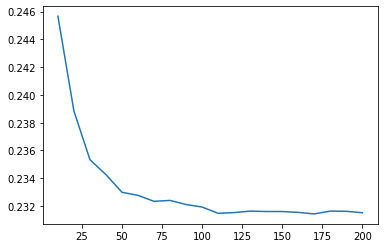

In [28]:
plt.plot(rf_scores.n_estimators, rf_scores.score);

I think it is `50` that the rmse score stops improving

### Question 4

In [29]:
scores = []

for d in [10, 15, 20, 25]:
    for n in range(10, 201, 10):
        rf = RandomForestRegressor(n_estimators=n,
                                   max_depth=d,
                                   random_state=1,
                                   n_jobs=1)
        rf.fit(X_train, y_train)

        y_pred = rf.predict(X_val)
        score = np.sqrt(mean_squared_error(y_pred, y_val))
        scores.append((d, n, score))

In [30]:
df_scores = pd.DataFrame(scores, columns=['max_depth', 'n_estimators','rmse'])
df_scores.head()

,max_depth,n_estimators,rmse
0,10,10,0.254599
1,10,20,0.252577
2,10,30,0.251463
3,10,40,0.250919
4,10,50,0.250069


In [31]:
df_scores[df_scores.max_depth == 10]

,max_depth,n_estimators,rmse
0,10,10,0.254599
1,10,20,0.252577
2,10,30,0.251463
3,10,40,0.250919
4,10,50,0.250069
5,10,60,0.250002
6,10,70,0.249847
7,10,80,0.249561
8,10,90,0.249289
9,10,100,0.249140


In [32]:
colors = ['black', 'red', 'blue', 'green']
depths = [10, 15, 20, 25]
list(zip(colors, depths))

[('black', 10), ('red', 15), ('blue', 20), ('green', 25)]

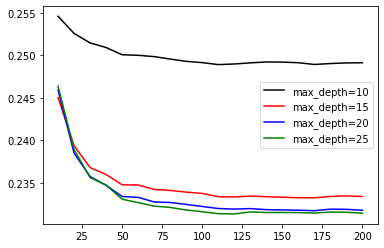

In [33]:

for o in zip(colors, depths):
    df_subset = df_scores[df_scores.max_depth == o[1]]
    plt.plot(df_subset.n_estimators, df_subset.rmse, color = o[0] , label='max_depth={}'.format(o[1]))
plt.legend()

seems it is `20`

### Question 5

In [34]:
 rf = RandomForestRegressor(n_estimators=10,
                                   max_depth=20,
                                   random_state=1,
                                   n_jobs=1)
rf.fit(X_train, y_train)

RandomForestRegressor(max_depth=20, n_estimators=10, n_jobs=1, random_state=1)

In [35]:
rf.feature_importances_

array([1.63873827e-02, 3.31454580e-02, 1.01255849e-01, 9.64702137e-02,
       3.63325843e-01, 2.48880276e-03, 3.10900842e-01, 3.56806263e-04,
       4.80369796e-04, 4.69876693e-03, 3.07769212e-02, 1.91716318e-02,
       2.05411131e-02])

In [36]:
max(rf.feature_importances_)

0.3633258427603735

In [37]:
len(dv.get_feature_names_out())

13

In [38]:
len(rf.feature_importances_)

13

<BarContainer object of 13 artists>

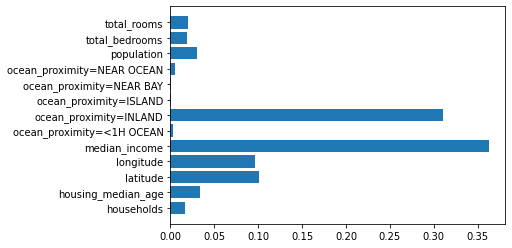

In [39]:
plt.barh(dv.get_feature_names_out(), rf.feature_importances_)

`Median Income` has the greates feature importance

In [40]:
features = dv.get_feature_names_out()
regex = re.compile(r"<", re.IGNORECASE)
features = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in features]
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=features)

In [41]:
# create watch list
watchlist = [(dtrain, 'train'), (dval, 'val')]

In [42]:
%%capture output
xgb_params = {
    'eta': 0.1, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}
model = xgb.train(xgb_params, dtrain, evals = watchlist, verbose_eval = 5, num_boost_round=100)

In [43]:
s = output.stdout

In [44]:
def parse_xgb_output(output):
    results = []

    for line in output.stdout.strip().split('\n'):
        it_line, train_line, val_line = line.split('\t')

        it = int(it_line.strip('[]'))
        train = float(train_line.split(':')[1])
        val = float(val_line.split(':')[1])

        results.append((it, train, val))
    
    columns = ['num_iter', 'train_rmse', 'val_rmse']
    df_results = pd.DataFrame(results, columns=columns)
    return df_results

In [45]:
df_scores = parse_xgb_output(output)

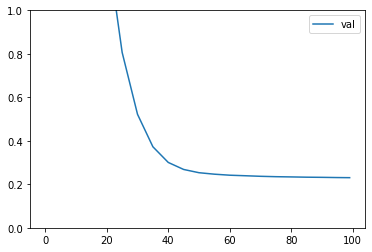

In [46]:
plt.plot(df_scores.num_iter, df_scores.val_rmse, label='val')
plt.ylim(0,1)
plt.legend()

In [47]:
# - 0.3 = 0.2260957847928297
# - 0.1 = 0.2305416021993131
y_pred = model.predict(dval)

In [48]:
np.sqrt(mean_squared_error(y_pred, y_val))

0.2305416021993131

In [49]:
Hence, 0.3 is the best eta

SyntaxError: invalid syntax (2140218402.py, line 1)